In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data_path =  "/content/drive/MyDrive/Colab Data/hostelworld_case_study.csv"

df = pd.read_csv(data_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109582 entries, 0 to 109581
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CUSTOMER_ID                  109582 non-null  int64  
 1   ACQ_MTH                      109582 non-null  int64  
 2   ACQ_TRIP_TYPE                109582 non-null  object 
 3   ACQ_BOOKING_PLATFORM         109582 non-null  object 
 4   ACQ_LENGTH_OF_STAY_CATEGORY  109582 non-null  object 
 5   ACQ_BOOKING_LEADTIME         109582 non-null  object 
 6   ACQ_BEDVALUE                 109582 non-null  float64
 7   LIFETIME_BEDVALUE            109582 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.7+ MB


In [5]:
df.describe(include="all")

,CUSTOMER_ID,ACQ_MTH,ACQ_TRIP_TYPE,ACQ_BOOKING_PLATFORM,ACQ_LENGTH_OF_STAY_CATEGORY,ACQ_BOOKING_LEADTIME,ACQ_BEDVALUE,LIFETIME_BEDVALUE
count,109582.000000,109582.000000,109582,109582,109582,109582,109582.000000,109582.000000
unique,NaN,NaN,3,2,4,6,NaN,NaN
top,NaN,NaN,Short Haul,WEB,1-2 Nights,7-30 days,NaN,NaN
freq,NaN,NaN,48512,64929,72450,34745,NaN,NaN
mean,54791.500000,6.504910,NaN,NaN,NaN,NaN,532.914171,7906.777532
std,31633.742936,3.444585,NaN,NaN,NaN,NaN,820.126167,15458.120252
min,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,27396.250000,4.000000,NaN,NaN,NaN,NaN,110.710000,775.157500
50%,54791.500000,6.000000,NaN,NaN,NaN,NaN,272.345000,2862.360000
75%,82186.750000,9.000000,NaN,NaN,NaN,NaN,629.185000,8382.755000


In [6]:
df.CUSTOMER_ID.agg(count="count", unique="nunique")

,CUSTOMER_ID
count,109582
unique,109582


In [7]:
df_cleaned = df.copy()

In [8]:
df_cleaned["ACQ_DECILES"] = pd.qcut(df_cleaned["ACQ_BEDVALUE"], q=10, labels=False, duplicates='drop')

In [9]:
df_cleaned["ACQ_TRIP_TYPE"] = df_cleaned["ACQ_TRIP_TYPE"].replace({
    "Domestic":"0. Domestic",
    "Short Haul":"1. Short Haul",
    "Long Haul":"2. Long Haul"
    })

In [10]:
df_cleaned["ACQ_BOOKING_LEADTIME"] = df_cleaned["ACQ_BOOKING_LEADTIME"].replace({
    "Same day":"0. Same day",
    "1-2 days":"1. 1-2 days",
    "3-6 days":"2. 3-6 days",
    "7-30 days":"3. 7-30 days",
    "31-60 days":"4. 31-60 days",
    "60+ days":"5. 60+ days"
})

In [11]:
# Combined bar charts with dual y-axes for distribution and average LTV of categorical variables
def avg_ltv_bar_chart(df, column):
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Distribution (Frequency)
    agg = df.groupby(column)['LIFETIME_BEDVALUE'].agg(
        avg_ltv="mean",
        freq="count"
    ).sort_index()

    # Setting bar width and positions
    bar_width = 0.4
    index = range(len(agg))
    adjusted_index = [i * 1.5 for i in index]  # Adding space between bars

    # Plotting the distribution on the left y-axis
    ax1.bar(adjusted_index, agg["freq"], width=bar_width, color='orange', alpha=0.7, label='Frequency')
    ax1.set_ylabel('Frequency', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.set_xticks([i + bar_width / 2 for i in adjusted_index])
    ax1.set_xticklabels(agg.index, rotation=45)
    ax1.set_ylim(0, agg["freq"].max() * 1.1)

    # Creating a second y-axis for Average LTV
    ax2 = ax1.twinx()
    ax2.bar([i + bar_width for i in adjusted_index], agg["avg_ltv"], width=bar_width, color='blue', alpha=0.7, label='Average LTV')
    ax2.set_ylabel('Average LTV', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, agg["avg_ltv"].max() * 1.1)

    # Title and legend
    plt.title(f"Distribution and Average LTV by {column}")
    fig.tight_layout()
    plt.show()

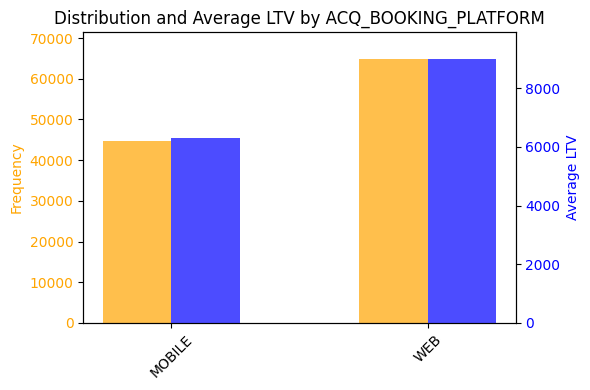

In [12]:
avg_ltv_bar_chart(df_cleaned, "ACQ_BOOKING_PLATFORM")

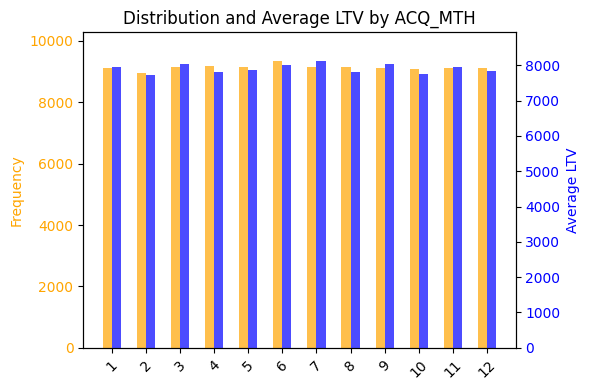

In [13]:
avg_ltv_bar_chart(df_cleaned, "ACQ_MTH")

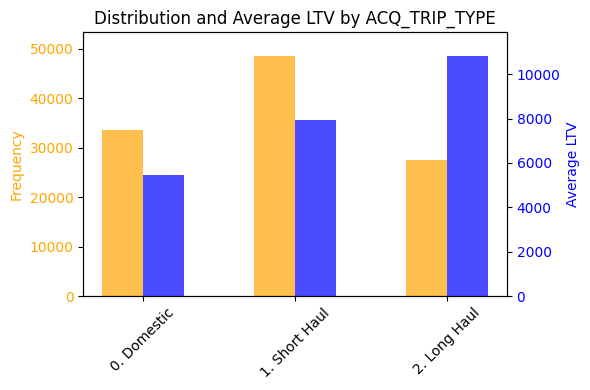

In [14]:
avg_ltv_bar_chart(df_cleaned, "ACQ_TRIP_TYPE")

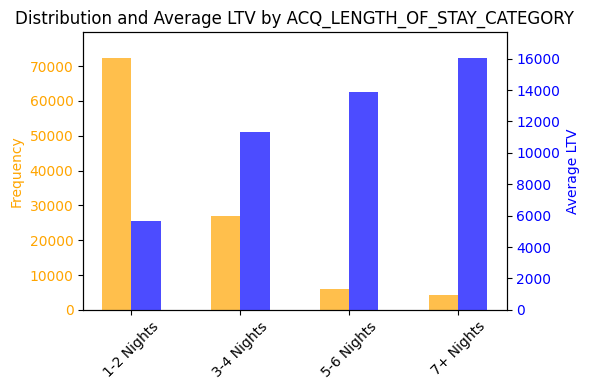

In [15]:
avg_ltv_bar_chart(df_cleaned, "ACQ_LENGTH_OF_STAY_CATEGORY")

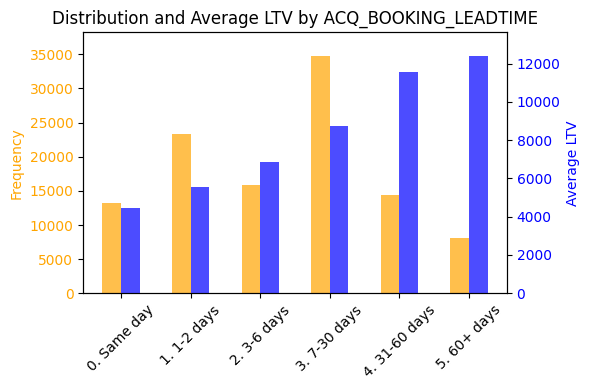

In [16]:
avg_ltv_bar_chart(df_cleaned, "ACQ_BOOKING_LEADTIME")

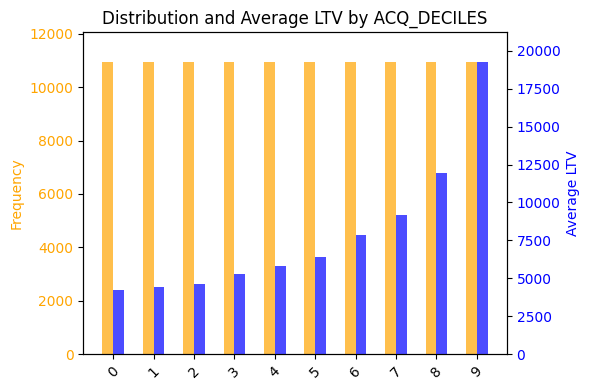

In [17]:
avg_ltv_bar_chart(df_cleaned, "ACQ_DECILES")

In [18]:
df_cleaned.groupby(["ACQ_TRIP_TYPE","ACQ_BOOKING_PLATFORM"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

freq     avg_acq       avg_ltv
ACQ_TRIP_TYPE ACQ_BOOKING_PLATFORM                                 
2. Long Haul  WEB                   21212  663.609792  11387.682363
              MOBILE                 6248  606.661128   8840.476477
1. Short Haul WEB                   29419  618.661655   8774.085808
              MOBILE                19093  480.924556   6688.437469
0. Domestic   WEB                   14298  450.999440   5935.155469
              MOBILE                19312  346.924262   5124.361033

In [19]:
df_cleaned.groupby(["ACQ_TRIP_TYPE","ACQ_LENGTH_OF_STAY_CATEGORY"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

freq      avg_acq       avg_ltv
ACQ_TRIP_TYPE ACQ_LENGTH_OF_STAY_CATEGORY                                  
2. Long Haul  7+ Nights                     1685  1630.722641  17691.706368
              5-6 Nights                    2091  1184.095878  16877.503534
0. Domestic   7+ Nights                      925  1297.763546  15239.703330
1. Short Haul 7+ Nights                     1596  1470.005802  14832.169505
2. Long Haul  3-4 Nights                    8456   850.615108  13470.728958
1. Short Haul 5-6 Nights                    2504  1178.385851  13353.334149
              3-4 Nights                   12161   864.838050  11612.185633
0. Domestic   5-6 Nights                    1343   919.721780  10265.050372
              3-4 Nights                    6371   617.034833   8036.131129
2. Long Haul  1-2 Nights                   15228   357.919370   7734.498695
1. Short Haul 1-2 Nights                   32251   358.705057   5813.850308
0. Domestic   1-2 Nights                   24971   271.572816   4194.530996

In [20]:
df_cleaned.groupby(["ACQ_TRIP_TYPE","ACQ_BOOKING_LEADTIME"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

freq     avg_acq       avg_ltv
ACQ_TRIP_TYPE ACQ_BOOKING_LEADTIME                                 
2. Long Haul  5. 60+ days            4306  917.565739  13434.978435
              4. 31-60 days          6561  776.277971  13039.236342
1. Short Haul 5. 60+ days            2919  968.374454  11787.612138
              4. 31-60 days          6229  843.818905  10932.891345
2. Long Haul  3. 7-30 days          10816  607.133924  10336.401252
0. Domestic   5. 60+ days             809  833.631199   8990.779333
1. Short Haul 3. 7-30 days          17146  626.711630   8576.282422
2. Long Haul  2. 3-6 days            2653  455.900332   8557.522386
0. Domestic   4. 31-60 days          1624  730.089932   7826.706262
1. Short Haul 2. 3-6 days            7490  460.385642   7130.318323
0. Domestic   3. 7-30 days           6783  549.141967   6621.467315
2. Long Haul  1. 1-2 days            2320  341.015190   6464.566767
1. Short Haul 1. 1-2 days            9549  373.972082   6037.034233
0. Domestic   2. 3-6 days            5649  389.862714   5628.488991
              1. 1-2 days           11482  309.703896   4977.864851
1. Short Haul 0. Same day            5179  296.374068   4868.794061
2. Long Haul  0. Same day             804  317.527935   4838.247264
0. Domestic   0. Same day            7263  248.510682   4126.918681

In [21]:
df_cleaned.groupby(["ACQ_BOOKING_PLATFORM","ACQ_LENGTH_OF_STAY_CATEGORY"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

,,freq,avg_acq,avg_ltv
ACQ_BOOKING_PLATFORM,ACQ_LENGTH_OF_STAY_CATEGORY,,,
WEB,7+ Nights,2909,1543.991244,16106.565490
MOBILE,7+ Nights,1297,1390.021326,15979.486762
WEB,5-6 Nights,4099,1163.766036,14490.512759
MOBILE,5-6 Nights,1839,1028.565536,12570.396656
WEB,3-4 Nights,17846,847.242678,12258.081731
MOBILE,3-4 Nights,9142,713.337668,9578.291227
WEB,1-2 Nights,40075,357.920094,6476.178770
MOBILE,1-2 Nights,32375,292.101621,4648.407775


In [22]:
df_cleaned.groupby(["ACQ_BOOKING_PLATFORM","ACQ_BOOKING_LEADTIME"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

freq     avg_acq       avg_ltv
ACQ_BOOKING_PLATFORM ACQ_BOOKING_LEADTIME                                 
WEB                  5. 60+ days            6145  914.085526  12641.978744
                     4. 31-60 days         11559  794.535919  12005.152357
MOBILE               5. 60+ days            1889  971.453245  11565.716289
                     4. 31-60 days          2855  823.444165   9665.297622
WEB                  3. 7-30 days          26119  607.066136   9100.595998
MOBILE               3. 7-30 days           8626  600.652409   7658.520785
WEB                  2. 3-6 days            9364  444.073702   7201.913365
MOBILE               2. 3-6 days            6428  420.320529   6295.240929
WEB                  1. 1-2 days            9258  351.771968   5739.478833
MOBILE               1. 1-2 days           14093  330.769169   5439.947773
                     0. Same day           10762  273.362423   4577.572772
WEB                  0. Same day            2484  262.971192   3951.452275

In [23]:
df_cleaned.groupby(["ACQ_LENGTH_OF_STAY_CATEGORY","ACQ_BOOKING_LEADTIME"]).agg(
    freq=("LIFETIME_BEDVALUE", "count"),
    avg_acq=("ACQ_BEDVALUE", "mean"),
    avg_ltv=("LIFETIME_BEDVALUE", "mean")
).sort_values(by="avg_ltv", ascending=False)

freq      avg_acq  \
ACQ_LENGTH_OF_STAY_CATEGORY ACQ_BOOKING_LEADTIME                       
7+ Nights                   5. 60+ days             608  2054.323684   
                            4. 31-60 days           838  1724.939523   
5-6 Nights                  5. 60+ days             817  1353.511714   
7+ Nights                   0. Same day             138  1131.605362   
5-6 Nights                  4. 31-60 days          1189  1305.135955   
7+ Nights                   3. 7-30 days           1553  1415.415390   
3-4 Nights                  4. 31-60 days          4734  1028.150881   
                            5. 60+ days            2846  1083.069108   
7+ Nights                   2. 3-6 days             571  1221.256445   
                            1. 1-2 days             498  1100.724900   
5-6 Nights                  3. 7-30 days           2252  1158.625364   
                            2. 3-6 days             777   875.164183   
3-4 Nights                  3. 7-30 days           9980   821.784208   
5-6 Nights                  0. Same day             203   814.939852   
                            1. 1-2 days             700   785.033714   
3-4 Nights                  2. 3-6 days            3574   633.762107   
1-2 Nights                  5. 60+ days            3763   535.441985   
3-4 Nights                  0. Same day            1427   549.699075   
                            1. 1-2 days            4427   551.310617   
1-2 Nights                  4. 31-60 days          7653   479.602971   
                            3. 7-30 days          20960   383.035175   
                            2. 3-6 days           10870   296.018467   
                            1. 1-2 days           17726   247.088913   
                            0. Same day           11478   216.861120   

                                                       avg_ltv  
ACQ_LENGTH_OF_STAY_CATEGORY ACQ_BOOKING_LEADTIME                
7+ Nights                   5. 60+ days           19950.481464  
                            4. 31-60 days         18841.497375  
5-6 Nights                  5. 60+ days           17986.226585  
7+ Nights                   0. Same day           17376.031667  
5-6 Nights                  4. 31-60 days         17096.750177  
7+ Nights                   3. 7-30 days          14654.771429  
3-4 Nights                  4. 31-60 days         14028.205363  
                            5. 60+ days           13813.718261  
7+ Nights                   2. 3-6 days           13611.094764  
                            1. 1-2 days           13517.345984  
5-6 Nights                  3. 7-30 days          12859.796976  
                            2. 3-6 days           11720.197452  
3-4 Nights                  3. 7-30 days          11663.611803  
5-6 Nights                  0. Same day           11252.190443  
                            1. 1-2 days           10199.624714  
3-4 Nights                  2. 3-6 days            9670.960106  
1-2 Nights                  5. 60+ days            8874.333093  
3-4 Nights                  0. Same day            8481.134807  
                            1. 1-2 days            8477.447940  
1-2 Nights                  4. 31-60 days          8341.205521  
                            3. 7-30 days           6471.321495  
                            2. 3-6 days            5194.294893  
                            1. 1-2 days            4422.895260  
                            0. Same day            3684.838754

In [24]:
df_cleaned.describe(include="all")

,CUSTOMER_ID,ACQ_MTH,ACQ_TRIP_TYPE,ACQ_BOOKING_PLATFORM,ACQ_LENGTH_OF_STAY_CATEGORY,ACQ_BOOKING_LEADTIME,ACQ_BEDVALUE,LIFETIME_BEDVALUE,ACQ_DECILES
count,109582.000000,109582.000000,109582,109582,109582,109582,109582.000000,109582.000000,109582.000000
unique,NaN,NaN,3,2,4,6,NaN,NaN,NaN
top,NaN,NaN,1. Short Haul,WEB,1-2 Nights,3. 7-30 days,NaN,NaN,NaN
freq,NaN,NaN,48512,64929,72450,34745,NaN,NaN,NaN
mean,54791.500000,6.504910,NaN,NaN,NaN,NaN,532.914171,7906.777532,4.499936
std,31633.742936,3.444585,NaN,NaN,NaN,NaN,820.126167,15458.120252,2.872336
min,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,27396.250000,4.000000,NaN,NaN,NaN,NaN,110.710000,775.157500,2.000000
50%,54791.500000,6.000000,NaN,NaN,NaN,NaN,272.345000,2862.360000,4.500000
75%,82186.750000,9.000000,NaN,NaN,NaN,NaN,629.185000,8382.755000,7.000000


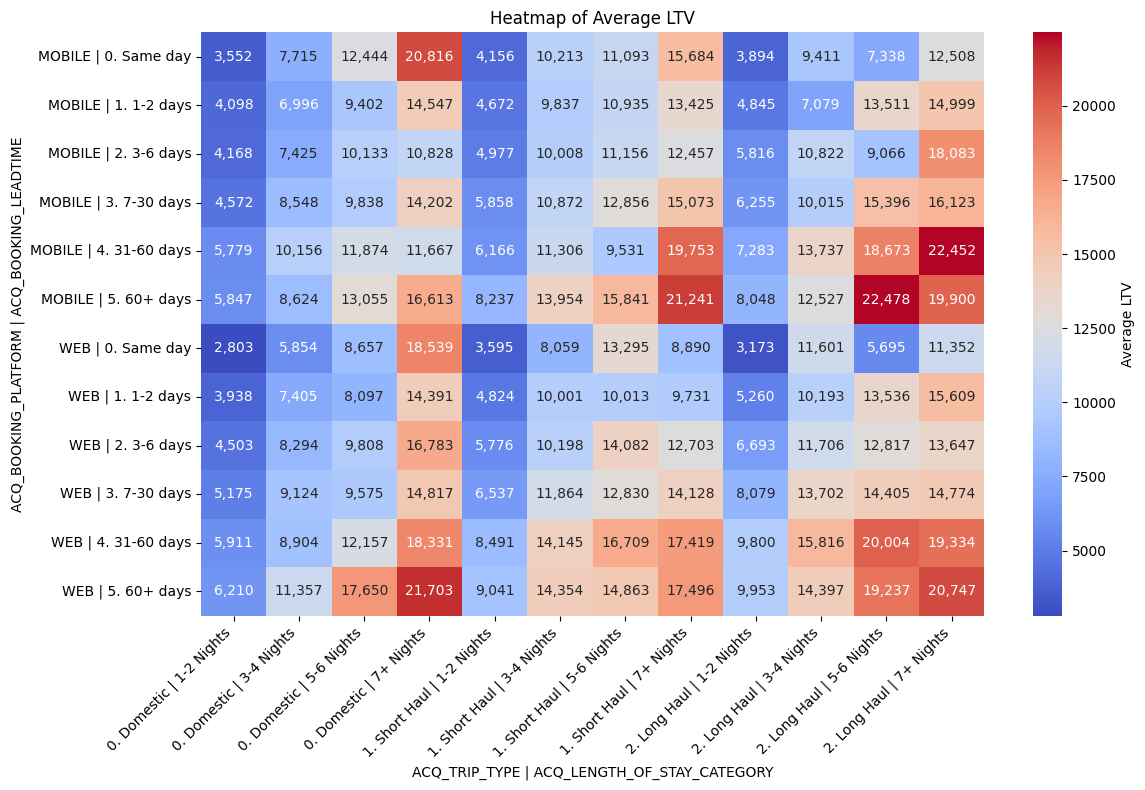

In [25]:
# Create compounded columns for x-axis and y-axis
df_cleaned['X_AXIS'] = df_cleaned['ACQ_TRIP_TYPE'] + " | " + df_cleaned['ACQ_LENGTH_OF_STAY_CATEGORY']
df_cleaned['Y_AXIS'] = df_cleaned['ACQ_BOOKING_PLATFORM'] + " | " + df_cleaned['ACQ_BOOKING_LEADTIME']

# Group by the compounded columns and calculate the average LTV
heatmap_data_ltv = df_cleaned.groupby(['Y_AXIS', 'X_AXIS'])['LIFETIME_BEDVALUE'].mean().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_ltv, annot=True, fmt=",.0f", cmap="coolwarm", cbar_kws={'label': 'Average LTV'})
plt.title("Heatmap of Average LTV")
plt.xlabel("ACQ_TRIP_TYPE | ACQ_LENGTH_OF_STAY_CATEGORY")
plt.ylabel("ACQ_BOOKING_PLATFORM | ACQ_BOOKING_LEADTIME")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

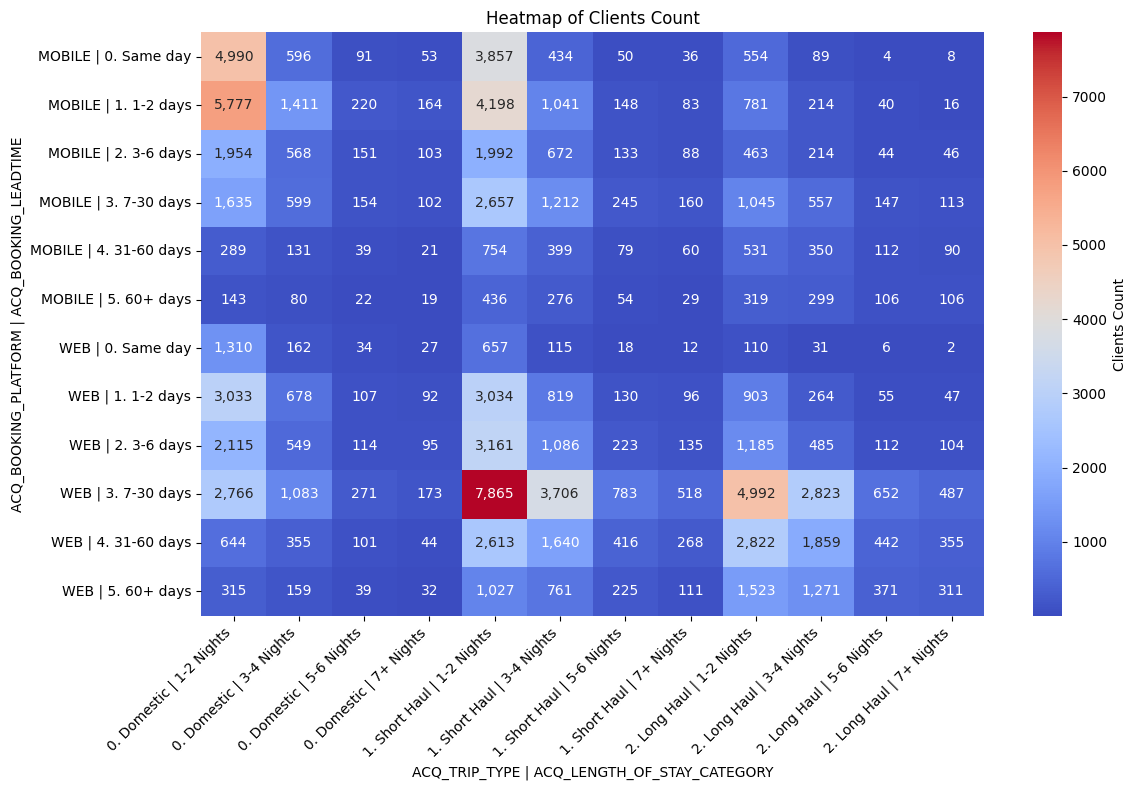

In [26]:
# Group by the compounded columns and calculate the count of clients
heatmap_data_cnt = df_cleaned.groupby(['Y_AXIS', 'X_AXIS'])['LIFETIME_BEDVALUE'].count().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_cnt, annot=True, fmt=",.0f", cmap="coolwarm", cbar_kws={'label': 'Clients Count'})
plt.title("Heatmap of Clients Count")
plt.xlabel("ACQ_TRIP_TYPE | ACQ_LENGTH_OF_STAY_CATEGORY")
plt.ylabel("ACQ_BOOKING_PLATFORM | ACQ_BOOKING_LEADTIME")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

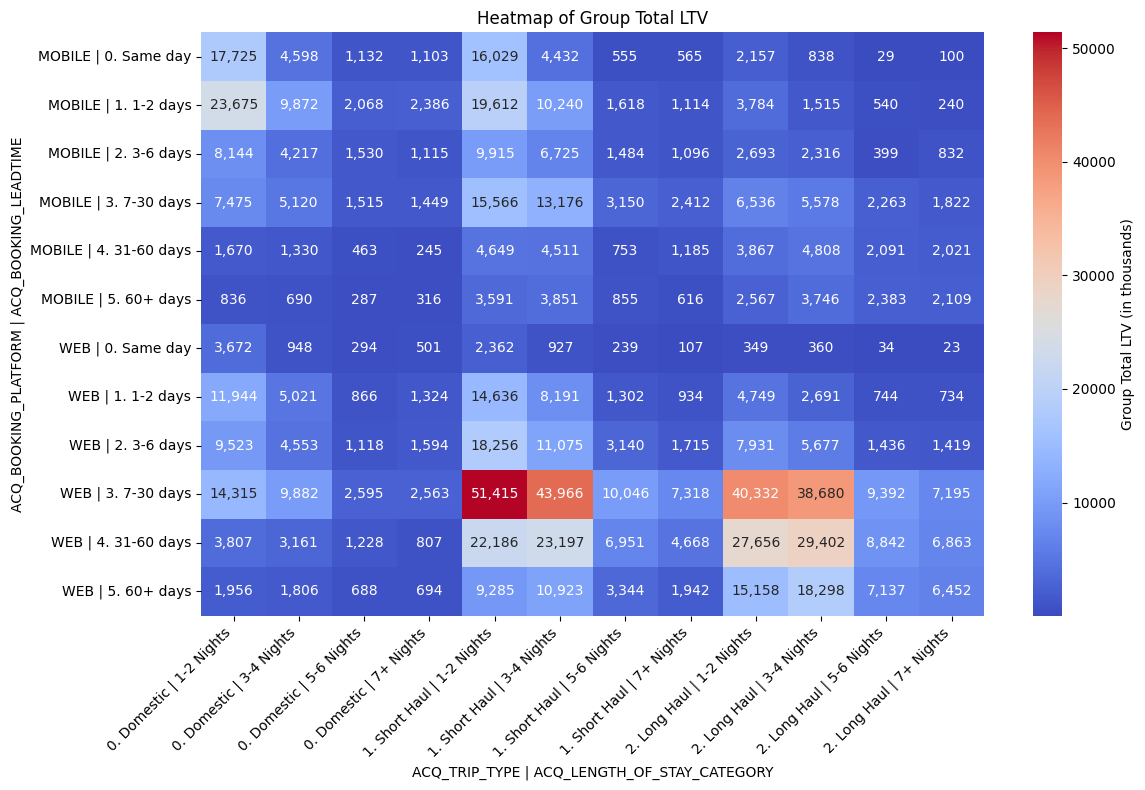

In [27]:
# Create compounded columns for x-axis and y-axis
df_cleaned['X_AXIS'] = df_cleaned['ACQ_TRIP_TYPE'] + " | " + df_cleaned['ACQ_LENGTH_OF_STAY_CATEGORY']
df_cleaned['Y_AXIS'] = df_cleaned['ACQ_BOOKING_PLATFORM'] + " | " + df_cleaned['ACQ_BOOKING_LEADTIME']

# Group by the compounded columns and calculate the total LTV
heatmap_data_profit = df_cleaned.groupby(['Y_AXIS', 'X_AXIS'])['LIFETIME_BEDVALUE'].sum().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_profit, annot=True, fmt=",.0f", cmap="coolwarm", cbar_kws={'label': 'Group Total LTV (in thousands)'})
plt.title("Heatmap of Group Total LTV")
plt.xlabel("ACQ_TRIP_TYPE | ACQ_LENGTH_OF_STAY_CATEGORY")
plt.ylabel("ACQ_BOOKING_PLATFORM | ACQ_BOOKING_LEADTIME")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()